In [1]:
import pandas as pd
import os
import boto3
import pystac_client
from dotenv import load_dotenv
from tqdm import tqdm
import numpy as np
import glob
import natsort
from PIL import Image

## Setup Environment

In [2]:
# Get credentials from environment variables
load_dotenv()
ACCESS_KEY_ID = os.environ.get("ACCESS_KEY_ID")
SECRET_ACCESS_KEY = os.environ.get("SECRET_ACCESS_KEY")

In [3]:
class S3Connector:
    """A clean connector for S3-compatible storage services"""

    def __init__(self, endpoint_url, access_key_id,
                 secret_access_key, region_name='default'):
        """Initialize the S3Connector with connection parameters"""
        self.endpoint_url = endpoint_url
        self.access_key_id = access_key_id
        self.secret_access_key = secret_access_key
        self.region_name = region_name

        # Create session
        self.session = boto3.session.Session()

        # Initialize S3 resource
        self.s3 = self.session.resource(
            's3',
            endpoint_url=self.endpoint_url,
            aws_access_key_id=self.access_key_id,
            aws_secret_access_key=self.secret_access_key,
            region_name=self.region_name
        )

        # Initialize S3 client
        self.s3_client = self.session.client(
            's3',
            endpoint_url=self.endpoint_url,
            aws_access_key_id=self.access_key_id,
            aws_secret_access_key=self.secret_access_key,
            region_name=self.region_name
        )

    def get_s3_client(self):
        """Get the boto3 S3 client"""
        return self.s3_client

    def get_s3_resource(self):
        """Get the boto3 S3 resource"""
        return self.s3

    def get_bucket(self, bucket_name):
        """Get a specific bucket by name"""
        return self.s3.Bucket(bucket_name)

    def list_buckets(self):
        """List all available buckets"""
        response = self.s3_client.list_buckets()
        if 'Buckets' in response:
            return [bucket['Name'] for bucket in response['Buckets']]
        return []

## Utility Functions

The following function helps convert S3 URIs from the STAC catalog into S3 keys that can be used for direct access.

In [4]:
ACCESS_KEY_ID = os.environ.get("ACCESS_KEY_ID")
SECRET_ACCESS_KEY = os.environ.get("SECRET_ACCESS_KEY")
ENDPOINT_URL = 'https://eodata.dataspace.copernicus.eu'
ENDPOINT_STAC = "https://stac.dataspace.copernicus.eu/v1/"
BUCKET_NAME = "eodata"
catalog = pystac_client.Client.open(ENDPOINT_STAC)
connector = S3Connector(
    endpoint_url=ENDPOINT_URL,
    access_key_id=ACCESS_KEY_ID,
    secret_access_key=SECRET_ACCESS_KEY,
    region_name='default'
)
# Get S3 client and resource from the connector instance
s3 = connector.get_s3_resource()
s3_client = connector.get_s3_client()
buckets = connector.list_buckets()
print("Available buckets:", buckets)

Available buckets: ['EODATA', 'DIAS']


In [5]:
def prepare_paths(path_dir):

    df_input = pd.read_csv(f"{path_dir}/input.csv")
    df_target = pd.read_csv(f"{path_dir}/target.csv")

    df_input["path"] = df_input["Name"].apply(lambda x: os.path.join(path_dir, "input", os.path.basename(x).replace(".SAFE","")))
    df_target["path"] = df_target["Name"].apply(lambda x: os.path.join(path_dir, "target", os.path.basename(x).replace(".SAFE","")))
    df_input["S3Path"] = df_input["S3Path"].apply(lambda x: f"s3:/{x}" if not x.startswith("s3://") else x)
    df_target["S3Path"] = df_target["S3Path"].apply(lambda x: f"s3:/{x}" if not x.startswith("s3://") else x)
    return df_input, df_target

version = "V3"
TRAIN_DIR = f"/mnt/disk/dataset/sentinel-ai-processor/{version}/train/"
VAL_DIR = f"/mnt/disk/dataset/sentinel-ai-processor/{version}/val/"
TEST_DIR = f"/mnt/disk/dataset/sentinel-ai-processor/{version}/test/"
df_train_input, df_train_target =  prepare_paths(TRAIN_DIR)
df_val_input, df_val_target =  prepare_paths(VAL_DIR)
df_test_input, df_test_target =  prepare_paths(TEST_DIR)

In [6]:
def calculate_valid_pixel_percentages(df, column_name="path", show_progress=True):
    """
    Calculate the percentage of valid (non-zero) pixels for each entry in the dataframe.

    Args:
        df (DataFrame): DataFrame containing paths to image folders.
        column_name (str): Name of the column in the dataframe that contains the image folder paths.
        show_progress (bool): Whether to show a progress bar.

    Returns:
        DataFrame: DataFrame with an additional column for valid pixel percentages.
    """
    valid_pixel_percentages = []

    # Create iterator with or without progress bar
    iterator = tqdm(range(len(df)), desc="Processing Valid Pixel", ncols=100, colour='#ff6666') if show_progress else range(len(df))

    for i in iterator:
        x_paths = natsort.natsorted(glob.glob(os.path.join(df[column_name][i], "*.png"), recursive=False))

        if not x_paths:
            valid_pixel_percentages.append(0)
            continue

        data = Image.open(x_paths[0])
        data = np.array(data)

        total_pixels = data.size
        pixels_greater_than_zero = np.sum(data > 0)
        percentage = (pixels_greater_than_zero / total_pixels) * 100
        valid_pixel_percentages.append(percentage)

    df['valid_pixel'] = valid_pixel_percentages
    return df

In [7]:
df_train_input = calculate_valid_pixel_percentages(df=df_train_input, column_name="path", show_progress=True)
df_val_input = calculate_valid_pixel_percentages(df=df_val_input, column_name="path", show_progress=True)
df_test_input = calculate_valid_pixel_percentages(df=df_test_input, column_name="path", show_progress=True)

Processing Valid Pixel: 100%|█████████████████████████████████████| 530/530 [00:29<00:00, 18.01it/s]


In [8]:
df_train_target = calculate_valid_pixel_percentages(df=df_train_target, column_name="path", show_progress=True)
df_val_target = calculate_valid_pixel_percentages(df=df_val_target, column_name="path", show_progress=True)
df_test_target = calculate_valid_pixel_percentages(df=df_test_target, column_name="path", show_progress=True)

Processing Valid Pixel: 100%|█████████████████████████████████████| 530/530 [00:30<00:00, 17.55it/s]


## Data filtering

Filter data based on L1C products features:

 - valid pixel = 100
 - cloud_cover < 30 % 

In [9]:
# get index of filtered data

train_index = df_train_input[
    (df_train_input['valid_pixel'] == 100) &
    (df_train_input['cloud_cover'] < 30)
].index

val_index = df_val_input[
    (df_val_input['valid_pixel'] == 100) &
    (df_val_input['cloud_cover'] < 30)
].index

test_index = df_test_input[
    (df_test_input['valid_pixel'] == 100) &
    (df_test_input['cloud_cover'] < 30)
].index

In [10]:
# Create new dataframe
df_train_input_new, df_train_target_new = df_train_input.loc[train_index], df_train_target.loc[train_index]
df_val_input_new, df_val_target_new = df_val_input.loc[val_index], df_val_target.loc[val_index]
df_test_input_new, df_test_target_new = df_test_input.loc[test_index], df_test_target.loc[test_index]

In [11]:
from sklearn.utils import shuffle

# Shuffle and reset index for train set

df_train_input_shuffle, df_train_target_shuffle = shuffle(df_train_input_new, df_train_target_new, random_state=42)
df_train_input_shuffle = df_train_input_shuffle.reset_index(drop=True)
df_train_target_shuffle = df_train_target_shuffle.reset_index(drop=True)

# Shuffle and reset index for validation set
df_val_input_shuffle, df_val_target_shuffle = shuffle(df_val_input_new, df_val_target_new, random_state=42)
df_val_input_shuffle = df_val_input_shuffle.reset_index(drop=True)
df_val_target_shuffle = df_val_target_shuffle.reset_index(drop=True)

# Shuffle and reset index for test set
df_test_input_shuffle, df_test_target_shuffle = shuffle(df_test_input_new, df_test_target_new, random_state=42)
df_test_input_shuffle = df_test_input_shuffle.reset_index(drop=True)
df_test_target_shuffle = df_test_target_shuffle.reset_index(drop=True)

<Axes: >

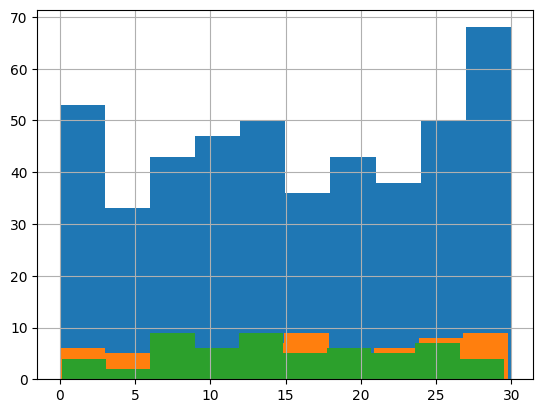

In [12]:
df_train_input_shuffle["cloud_cover"].hist()
df_val_input_shuffle["cloud_cover"].hist()
df_test_input_shuffle["cloud_cover"].hist()

In [13]:
# Data split for the V4 dataset
# 100 random tiles
# 70 / 20 / 10

dfs_train_input, dfs_train_target = df_train_input_shuffle[:70], df_train_target_shuffle[:70]
dfs_val_input, dfs_val_target = df_val_input_shuffle[:20], df_val_target_shuffle[:20]
dfs_test_input, dfs_test_target = df_test_input_shuffle[:10], df_test_target_shuffle[:10]

## Save 

In [14]:
import os

def save_dataframes_to_csv(
    dfs_train_input, dfs_train_target,
    dfs_val_input, dfs_val_target,
    dfs_test_input, dfs_test_target,
    base_dir="/mnt/disk/dataset/sentinel-ai-processor",
    version="V4"
):
    # Define full paths
    TRAIN_DIR = os.path.join(base_dir, version, "train")
    VAL_DIR = os.path.join(base_dir, version, "val")
    TEST_DIR = os.path.join(base_dir, version, "test")

    os.makedirs(TRAIN_DIR, exist_ok=True)
    os.makedirs(VAL_DIR, exist_ok=True)
    os.makedirs(TEST_DIR, exist_ok=True)

    # Save train
    dfs_train_input.to_csv(os.path.join(TRAIN_DIR, "input.csv"), index=False)
    dfs_train_target.to_csv(os.path.join(TRAIN_DIR, "target.csv"), index=False)

    # Save val
    dfs_val_input.to_csv(os.path.join(VAL_DIR, "input.csv"), index=False)
    dfs_val_target.to_csv(os.path.join(VAL_DIR, "target.csv"), index=False)

    # Save test
    dfs_test_input.to_csv(os.path.join(TEST_DIR, "input.csv"), index=False)
    dfs_test_target.to_csv(os.path.join(TEST_DIR, "target.csv"), index=False)

    print("✅ DataFrames saved successfully.")

In [15]:
save_dataframes_to_csv(
    dfs_train_input, dfs_train_target,
    dfs_val_input, dfs_val_target,
    dfs_test_input, dfs_test_target,
    version="V4"
)

✅ DataFrames saved successfully.


In [ ]:
product_url = df_train_input["S3Path"][0]
product_url

In [ ]:
# Replace .SAFE with .zarr
zarr_filename =  os.path.split(product_url)[1].replace('.SAFE', '.zarr')
# Join the current directory path with the new filename
zarr_path = os.path.join("./", zarr_filename)

In [ ]:
from eopf.common.constants import OpeningMode
from eopf.common.file_utils import AnyPath

S3_CONFIG = {
    "key": ACCESS_KEY_ID, # EDIT WITH YOUR S3 KEY
    "secret": SECRET_ACCESS_KEY, # EDIT WITH YOUR S3 SECRET KEY
    "client_kwargs": { "endpoint_url": ENDPOINT_URL, "region_name": "default"} # EDIT WITH YOUR CLIENT_KWARGS
}
# Add this parameter if you want to overwrite the output of the conversion if it already exists
target_store_config = dict(mode=OpeningMode.CREATE_OVERWRITE)

In [ ]:
from eopf.store.convert import convert

convert(AnyPath(product_url, **S3_CONFIG), zarr_path, target_store_kwargs=target_store_config)